In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats.distributions import chi2

<h1>Task 1</h1>

In [2]:
oats = pd.read_csv('/Users/herrakaava/Documents/school/sekamallit/week_4/oats.csv', index_col=0)

In [3]:
oats.head()

,Block,Variety,nitro,yield
1,I,Victory,0.0,111
2,I,Victory,0.2,130
3,I,Victory,0.4,157
4,I,Victory,0.6,174
5,I,Golden Rain,0.0,117


In [4]:
oats.index -= 1

In [5]:
oats = oats.rename(columns={'yield': 'Yield'})

In [6]:
oats.head()

,Block,Variety,nitro,Yield
0,I,Victory,0.0,111
1,I,Victory,0.2,130
2,I,Victory,0.4,157
3,I,Victory,0.6,174
4,I,Golden Rain,0.0,117


In [7]:
oats.shape

(72, 4)

In [8]:
oats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 0 to 71
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Block    72 non-null     object 
 1   Variety  72 non-null     object 
 2   nitro    72 non-null     float64
 3   Yield    72 non-null     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 2.8+ KB


In [9]:
oats.isna().any()

Block      False
Variety    False
nitro      False
Yield      False
dtype: bool

In [10]:
oats['Block'].value_counts()

Block
I      12
II     12
III    12
IV     12
V      12
VI     12
Name: count, dtype: int64

In [11]:
oats['Variety'].value_counts()

Variety
Victory        24
Golden Rain    24
Marvellous     24
Name: count, dtype: int64

In [12]:
oats['Yield'].unique()

array([111, 130, 157, 174, 117, 114, 161, 141, 105, 140, 118, 156,  61,
        91,  97, 100,  70, 108, 126, 149,  96, 124, 121, 144,  68,  64,
       112,  86,  60, 102,  89, 129, 132,  74,  81, 122, 103, 133, 104,
        62,  90, 116,  80,  82,  94,  63, 109,  99,  53, 113, 119])

<h3>Visuals</h3>

In [13]:
def visualize(df):
    """
    Notes:
    - g.axes.flat is used to access the individual axes (subplots)
      in a FacetGrid as a flat (1D) array.
    """
    # Create the grid for the faceting
    g = sns.FacetGrid(data=df, 
                      col='Block', 
                      hue='Variety', 
                      col_wrap=3,
                      sharex=True,
                      sharey=True,
                      height=5,
                      aspect=0.55)
    g.map(sns.lineplot, 'nitro', 'Yield', marker='o')
    
    for ax in g.axes.flat:
        ax.grid(True, alpha=0.3)
    
    g.add_legend()

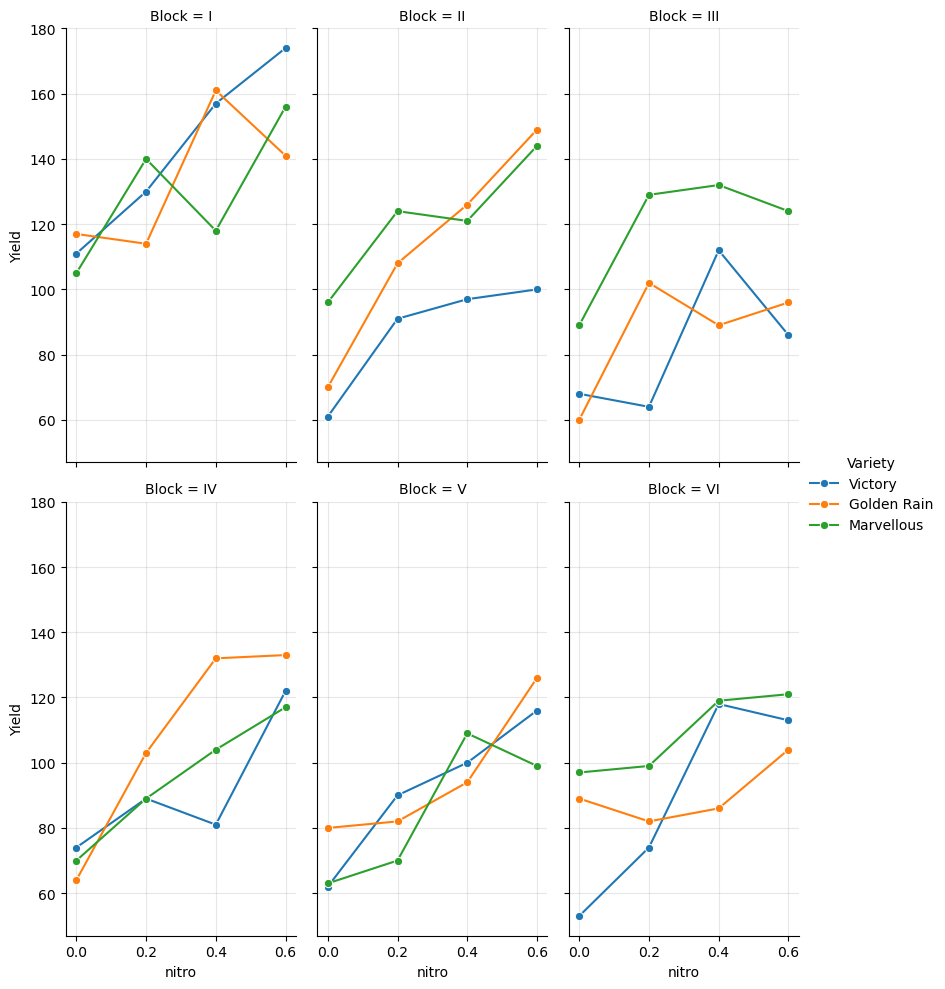

In [14]:
visualize(oats)

In [15]:
oats.groupby('nitro')['Yield'].mean()

nitro
0.0     79.388889
0.2     98.888889
0.4    114.222222
0.6    123.388889
Name: Yield, dtype: float64

In [16]:
oats.groupby('Variety')['Yield'].mean()

Variety
Golden Rain    104.500000
Marvellous     109.791667
Victory         97.625000
Name: Yield, dtype: float64

In [17]:
oats.groupby('Variety')['Yield'].min()

Variety
Golden Rain    60
Marvellous     63
Victory        53
Name: Yield, dtype: int64

In [18]:
oats.groupby('Variety')['Yield'].max()

Variety
Golden Rain    161
Marvellous     156
Victory        174
Name: Yield, dtype: int64

<h3>Fitting</h3>

In [19]:
def model_1(df):
    """
    Fits a mixed-effects model where each unique area gets its own random intercept.
    """
    model = smf.mixedlm(formula='Yield ~ nitro + Variety',
                        data=df,
                        groups=df.index)
    fit = model.fit()
    return model, fit

In [20]:
m1, f1, = model_1(oats)

/Users/herrakaava/anaconda3/envs/sekamallit/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [21]:
def model_2(df):
    model = smf.mixedlm(formula='Yield ~ nitro + Variety',
                        data=df,
                        groups='Block',
                        vc_formula={'Block:reika': '0 + C(Block):C(Variety)'})
    fit = model.fit()
    return model, fit

'**vc_formula**'

- 'Block:Variety' is a name tag for the summary output
- '0 + ' specifies that only a random intercept is being fitted (i.e., no random slopes)
- C(Block):C(Variety)' specifies an interaction between the categorical variables *Block* and *Variety*.
- (C() defines a categorical variable in the formula)

In [10]:
def corr_mat_fe(fit):
    """
    Params:
    fit -- a fitted (statsmodels mixedlm) model
    
    Notes:
    - To remove the custom float formatting, use: pd.reset_option('display.float_format')
    """
    # Set Pandas to display floats with 3 decimal places
    pd.options.display.float_format = '{:.3f}'.format
    
    # The covariance matrix of the fitted model
    S = fit.cov_params()
    
    # Filter the covariance matrix s.t. it contains only the fixed effects
    S_fe = fit.cov_params().loc[list(fit.fe_params.index), list(fit.fe_params.index)]
    
    # Standard deviations of the estimated parameters
    sd_params = np.sqrt(np.diag(S_fe))
    
    # The correlation matrix
    R = S_fe / np.outer(sd_params, sd_params)
    
    # Make it a lower triangular matrix
    R.values[np.triu_indices_from(R, k=1)] = np.nan
    R = R.map(lambda x: '' if pd.isna(x) else x)
    
    return R

In [23]:
def tukey_hsd(df):
    result = pairwise_tukeyhsd(endog=df['Yield'],
                               groups=df['Variety'],
                               alpha=0.05)
    print(result)

In [24]:
m2, f2 = model_2(oats)

In [25]:
print(f2.summary())

              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    Yield    
No. Observations:      72         Method:                REML     
No. Groups:            6          Scale:                 165.5585 
Min. group size:       12         Log-Likelihood:        -291.9350
Max. group size:       12         Converged:             Yes      
Mean group size:       12.0                                       
------------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------
Intercept              82.400    8.059 10.225 0.000  66.605 98.195
Variety[T.Marvellous]   5.292   11.027  0.480 0.631 -16.322 26.905
Variety[T.Victory]     -6.875   11.027 -0.623 0.533 -28.488 14.738
nitro                  73.667    6.781 10.863 0.000  60.375 86.958
Block:reika Var       323.420   11.727                            



In [26]:
corr_mat_fe(f2)

,Intercept,Variety[T.Marvellous],Variety[T.Victory],nitro
Intercept,1.000,,,
Variety[T.Marvellous],-0.684,1.000,,
Variety[T.Victory],-0.684,0.500,1.000,
nitro,-0.252,-0.000,-0.000,1.000


In [27]:
tukey_hsd(oats)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1     group2   meandiff p-adj   lower    upper  reject
--------------------------------------------------------------
Golden Rain Marvellous   5.2917 0.7761 -13.3591 23.9424  False
Golden Rain    Victory   -6.875 0.6528 -25.5258 11.7758  False
 Marvellous    Victory -12.1667 0.2687 -30.8174  6.4841  False
--------------------------------------------------------------


<h1>Task 3</h1>

In [2]:
machines = pd.read_csv("/Users/herrakaava/Documents/school/sekamallit/week_3/Machines.csv", index_col=0)

In [3]:
machines.head()

,Worker,Machine,score
1,1,A,52.0
2,1,A,52.8
3,1,A,53.1
4,2,A,51.8
5,2,A,52.8


In [4]:
machines.index -= 1

In [5]:
machines.head()

,Worker,Machine,score
0,1,A,52.0
1,1,A,52.8
2,1,A,53.1
3,2,A,51.8
4,2,A,52.8


In [6]:
machines.shape

(54, 3)

In [7]:
machines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Worker   54 non-null     int64  
 1   Machine  54 non-null     object 
 2   score    54 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ KB


In [8]:
machines.isna().any()

Worker     False
Machine    False
score      False
dtype: bool

<h3>Fitting</h3>

In [2]:
def model_3(df):
    model = smf.mixedlm(formula='score ~ Machine',
                        data=df,
                        groups='Worker',
                        re_formula='1')
    fit = model.fit()
    return model, fit

In [64]:
m3, f3 = model_3(machines)

In [65]:
print(f3.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score    
No. Observations: 54      Method:             REML     
No. Groups:       6       Scale:              9.9960   
Min. group size:  9       Log-Likelihood:     -143.4391
Max. group size:  9       Converged:          Yes      
Mean group size:  9.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    52.356    2.229 23.485 0.000 47.986 56.725
Machine[T.B]  7.967    1.054  7.559 0.000  5.901 10.032
Machine[T.C] 13.917    1.054 13.205 0.000 11.851 15.982
Worker Var   26.487    5.813                           



In [18]:
corr_mat_fe(f3)

,Intercept,Machine[T.B],Machine[T.C]
Intercept,1.000,,
Machine[T.B],-0.236,1.000,
Machine[T.C],-0.236,0.500,1.000


In [46]:
def plot_resid(fit):
    residuals = fit.resid
    fitted_vals = fit.fittedvalues
    fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=2, dpi=150)
    
    ax[0].scatter(residuals.index, residuals, facecolors="none", edgecolors="black")
    ax[0].axhline(y=0)
    ax[0].set_title('Residuals vs. index', size=12)
    
    ax[1].scatter(fitted_vals, residuals, facecolors="none", edgecolors="black")
    ax[1].axhline(y=0)
    ax[1].set_title('Residuals vs. fitted values', size=12)

In [134]:
def simulate_data(data, fit, rounds_per_machine=3):
    # The random effect variance
    tau_sq = fit.cov_re.iloc[0, 0]
    
    # The residual variance
    sigma_sq = fit.scale
    
    # Unique machines
    machines = list(data["Machine"].unique())
    
    # Unique workers
    workers = list(data["Worker"].unique())
    
    # Fixed effects for machines
    ic = fit.fe_params["Intercept"]
    machine_effects = {
        "A": 0,    # Contained as the reference level in the intercept
        "B": fit.fe_params["Machine[T.B]"],
        "C": fit.fe_params["Machine[T.C]"]
    }
    
    ##### Simulate data #####
    simulated_scores = []
    for worker in workers:
        # Random intercept for the ith worker from N(0, tau^2)
        random_ic = np.random.normal(0, np.sqrt(tau_sq))
        # Generate simulations
        for machine in machines:
            for _ in range(rounds_per_machine):
                # Fixed effect + random (worker) effect + residual (noise)
                score = ic + random_ic + machine_effects[machine] + np.random.normal(0, np.sqrt(sigma_sq))
                simulated_scores.append(score)
    
    ##### Construct a new df with the original features and the simulated scores #####
    simulated_df = data.drop("score", axis=1)
    simulated_df["sim_score"] = simulated_scores
    return simulated_df
    

In [128]:
def plot_simulated_residuals(df):
    # Fit the model with the simulated data
    model = smf.mixedlm(formula='sim_score ~ Machine',
                        data=df,
                        groups='Worker',
                        re_formula='1')
    fit = model.fit()
    
    # Residuals and fitted values
    residuals = fit.resid
    fitted_vals = fit.fittedvalues
    
    ##### Plotting #####
    fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=2, dpi=150)
    
    ax[0].scatter(residuals.index, residuals, facecolors="none", edgecolors="black")
    ax[0].axhline(y=0)
    ax[0].set_title('(simulated) Residuals vs. index', size=12)
    
    ax[1].scatter(fitted_vals, residuals, facecolors="none", edgecolors="black")
    ax[1].axhline(y=0)
    ax[1].set_title('(simulated) Residuals vs. fitted values', size=12)

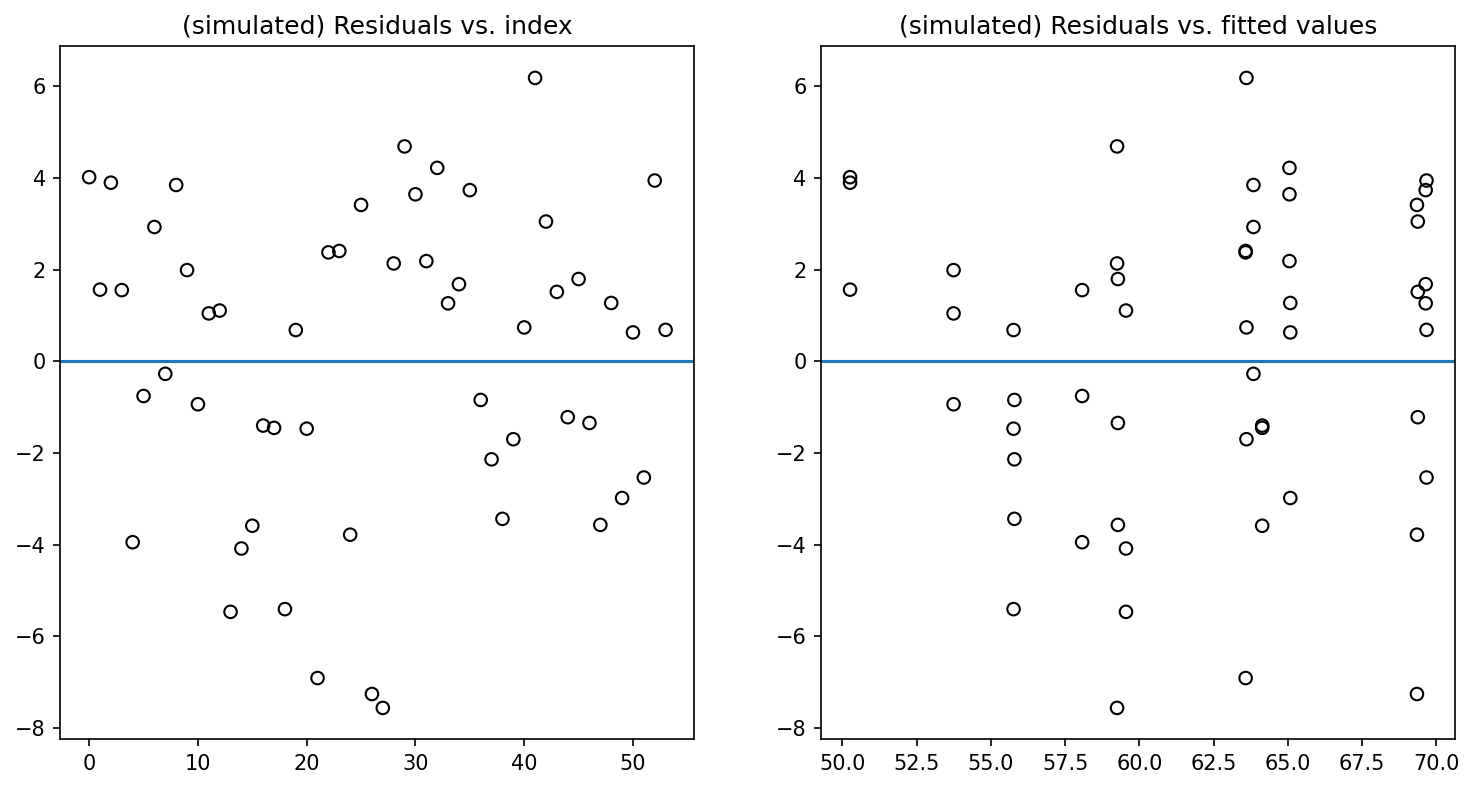

In [135]:
machines_sim = simulate_data(data=machines, fit=f3)
plot_simulated_residuals(machines_sim)

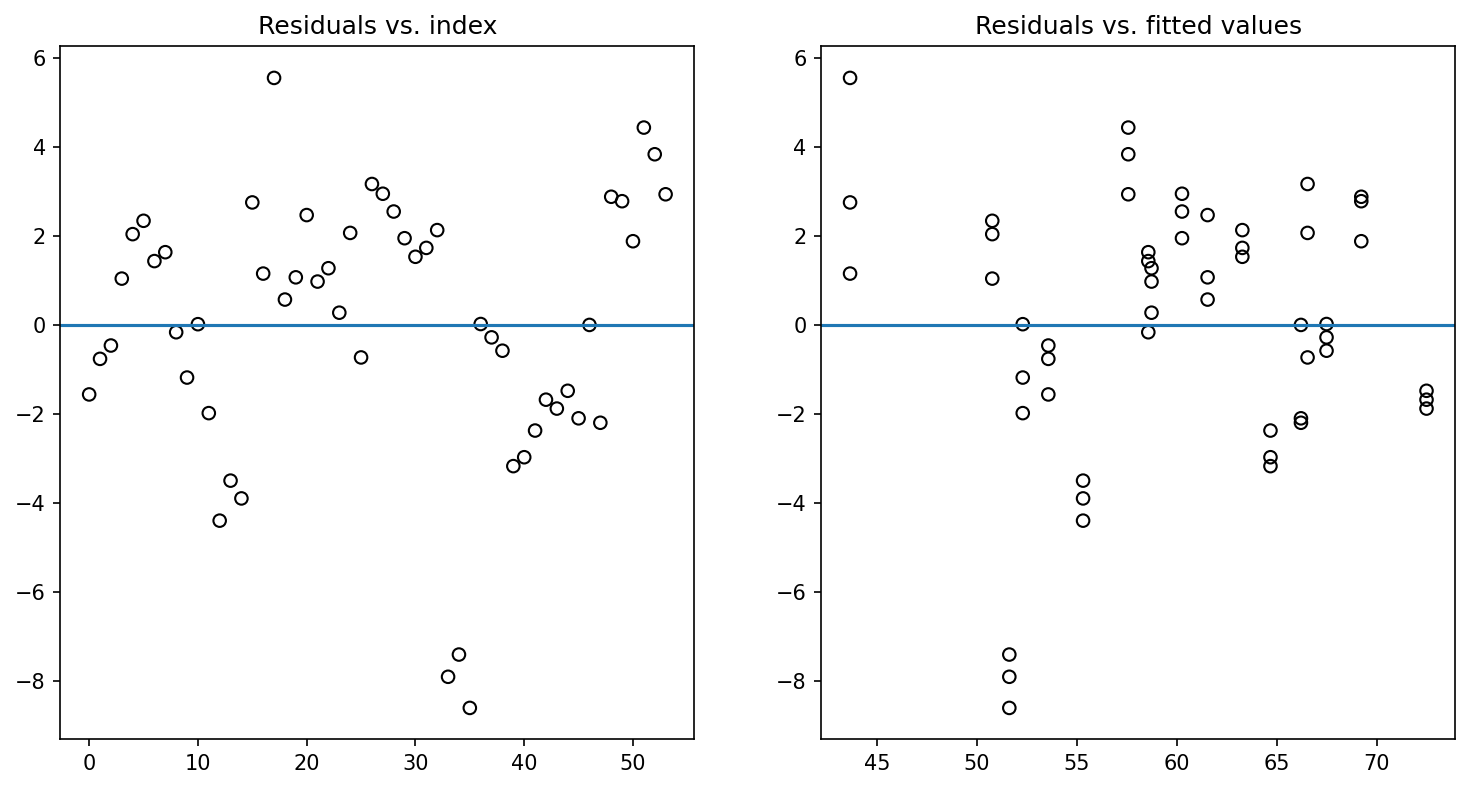

In [130]:
plot_resid(f3)

In [136]:
def fit_simulated_data(df):
    # Fit the model with the simulated data
    model = smf.mixedlm(formula='sim_score ~ Machine',
                        data=df,
                        groups='Worker',
                        re_formula='1')
    fit = model.fit()
    return model, fit

In [137]:
model_sim, fit_sim = fit_simulated_data(machines_sim)

In [142]:
print(fit_sim.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sim_score
No. Observations: 54      Method:             REML     
No. Groups:       6       Scale:              12.4858  
Min. group size:  9       Log-Likelihood:     -149.0064
Max. group size:  9       Converged:          Yes      
Mean group size:  9.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    58.264    2.444 23.839 0.000 53.474 63.054
Machine[T.B]  5.504    1.178  4.673 0.000  3.196  7.813
Machine[T.C]  5.532    1.178  4.697 0.000  3.224  7.841
Worker Var   31.679    6.232                           



In [143]:
print(f3.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score    
No. Observations: 54      Method:             REML     
No. Groups:       6       Scale:              9.9960   
Min. group size:  9       Log-Likelihood:     -143.4391
Max. group size:  9       Converged:          Yes      
Mean group size:  9.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    52.356    2.229 23.485 0.000 47.986 56.725
Machine[T.B]  7.967    1.054  7.559 0.000  5.901 10.032
Machine[T.C] 13.917    1.054 13.205 0.000 11.851 15.982
Worker Var   26.487    5.813                           



<h3>Task 4</h3>

In [2]:
sleep = pd.read_csv('/Users/herrakaava/Documents/school/sekamallit/week_2/sleep_study.csv', index_col=0)

In [3]:
sleep.head()

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308


<h3>Visuals</h3>

In [4]:
def f(data):
    unique_subjects = data['Subject'].unique()    # Unique subjects
    fig, ax = plt.subplots(figsize=(12,6), 
                           dpi=100, 
                           nrows=2, 
                           ncols=9,
                           sharex=True,
                           sharey=True)
    ax = ax.ravel()
    for i in range(unique_subjects.size):
        # Filter data to contain only a specific subject
        subject_i = data[data['Subject'] == unique_subjects[i]]
        
        # Best-fit line for the ith subject
        fit_i = smf.ols('Reaction ~ Days', data=subject_i).fit()
        params = fit_i.params.values
        
        ax[i].plot(subject_i['Days'].values, 
                   subject_i['Reaction'].values, 
                   marker='o', 
                   markerfacecolor='none',
                   linestyle='none',
                   color='black')
        ax[i].set_title(f'{unique_subjects[i]}')
        ax[i].grid(True)
        ax[i].set_xticks([0, 2, 4, 6, 8])
        
        # Plot best fit line of the ith subject
        ax[i].plot(subject_i['Days'].values, 
                   params[0] + subject_i['Days'].values * params[1])
        
    plt.tight_layout()

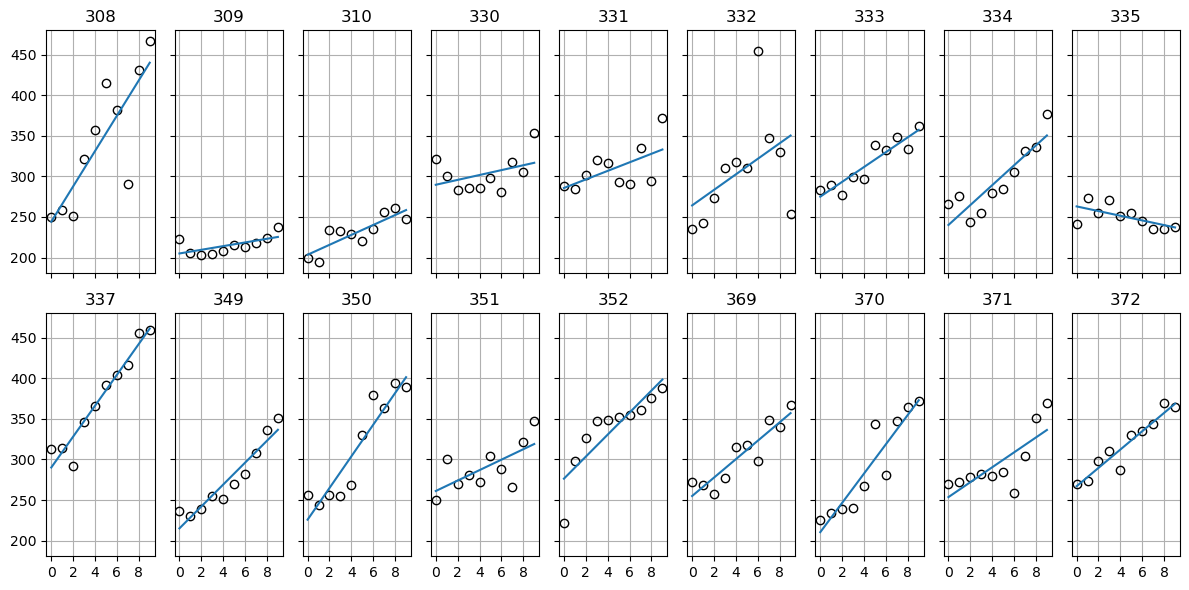

In [5]:
f(sleep)

<h3>Fitting</h3>

In [6]:
def M1(df):
    """
    Notes:
    - re_formula specifies the random effect structure.
      It specifies which variables will have varying (random) slopes and/or
      intercepts across the levels of the goruping variable.
    """
    model = smf.mixedlm(formula='Reaction ~ Days',
                        data=df,
                        groups='Subject',
                        re_formula='1 + Days')
    fit = model.fit(reml=False)
    return model, fit

- re_formula='1 + Days' specifies that both the intercept and the slope for *Days* will vary randomly for each *Subject* (i.e., each subjects can have a different baseline reaction time (random intercept) and a different effect of *Days* on reaction time (random slope)).

In [7]:
model1, fit1 = M1(sleep)

In [8]:
print(fit1.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Reaction 
No. Observations:    180        Method:                ML       
No. Groups:          18         Scale:                 654.9400 
Min. group size:     10         Log-Likelihood:        -875.9697
Max. group size:     10         Converged:             Yes      
Mean group size:     10.0                                       
----------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          251.405    6.632 37.906 0.000 238.406 264.404
Days                10.467    1.502  6.968 0.000   7.523  13.412
Subject Var        565.519   10.938                             
Subject x Days Cov  11.056    1.671                             
Days Var            32.683    0.561                             



In [11]:
corr_mat_fe(fit1)

,Intercept,Days
Intercept,1.000,
Days,-0.138,1.000


In [12]:
def M2(df):
    ref = '0 + Days'
    vcf = {'Subject': '0 + C(Subject)'}
    model = smf.mixedlm("Reaction ~ Days", 
                        data=df, 
                        groups=df["Subject"], 
                        re_formula=ref,
                        vc_formula=vcf)
                    
    fit = model.fit(reml=False)
    return model, fit

re_formula='0 + Days' 
- Includes a random slope for *Days*, but not a random intercept (for *Days*).

vc_formula={'Subject': '0 + C(Subject)'}
- Specifies a random intercept for each level of the categorical variable *Subject*.
- The '0 + ' part ensures that no overall intercept is included.

In [13]:
model2, fit2 = M2(sleep)

In [14]:
print(fit2.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Reaction 
No. Observations:   180     Method:             ML       
No. Groups:         18      Scale:              653.1160 
Min. group size:    10      Log-Likelihood:     -876.0016
Max. group size:    10      Converged:          Yes      
Mean group size:    10.0                                 
---------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   251.405    6.708 37.480 0.000 238.258 264.552
Days         10.467    1.519  6.889 0.000   7.489  13.445
Days Var     33.633    0.550                             
Subject Var 584.251   10.726                             



<h3>Testing</h3>

The likelihood ratio test is based on the comparison of the values $\, L(\hat{\theta}) \,$ and $\, L(\theta_0). \,$ 

The likelihood ratio itself is a ratio of these two likelihoods:

$$ LR(\theta)=\frac{L(\theta)}{L(\hat{\theta})}. $$

The test statistic is given by

$$ D = -2[l(\theta_0) - l(\hat{\theta})]. $$

\begin{align*}
    H_0 &= \text{The models M1 and M2 fit to the data equally good}\\
    H_1 &= \text{The more complex model fits the data better}
\end{align*}

Given the null hypothesis $\, \theta_{full} = \theta_{reduced} \,$ (i.e., the simpler model fits the data as well as the more complex model), the test statistic $\, D \sim \chi^2(dof), \,$ where the degrees of freedom (dof) is given by the difference in the number of parameters between the models being compared.

In [15]:
def LR_test(f1, f2, dof1, dof2):
    """
    Notes:
    - Typically the model with fewer parameters is treated ad the null model (theta_0),
      and the model with more parameters is the alternative model (theta_hat).
    """
    D = -2*(f2.llf - f1.llf)
    p = chi2.sf(D, 1)
    df = pd.DataFrame({
        'npar': [dof2, dof1],
        'AIC': [f2.aic, f1.aic],
        'BIC': [f2.bic, f1.bic],
        'LL': [f2.llf, f1.llf],
        'D': [None, D],
        'DoF': [None, int(dof1-dof2)],
        'Pr(>Chisq)': [None, p],
    }, index=['fit_2', 'fit_1'])
    pd.options.display.float_format = '{:.4f}'.format
    df = df.map(lambda x: '' if pd.isna(x) else x)
    df['DoF'] = df['DoF'].map(lambda x: '{:.2}'.format(x))
    return df

In [16]:
LR_test(f1=fit1, f2=fit2, dof1=6, dof2=5)

,npar,AIC,BIC,LL,D,DoF,Pr(>Chisq)
fit_2,5,1762.0033,1777.9680,-876.0016,,,
fit_1,6,1763.9393,1783.0971,-875.9697,0.0639,1.0,0.8004


- Given the large **p-value**, there is not enough evidence to reject the null hypothesis.
- This means that the more complex model does not provide a better fit to the data.
- In this situation, according to the Occam's razor principle, we choose the simpler model (**fit2**).

In [17]:
def pearson_resid(f):
    """
    The formula for Pearson residuals is:
    r_i = (y_i - hat{y_i}) / sigma,
    where sigma is the standard deviation of the residuals.
    """
    ##### Pearson residuals #####
    fit_resid = f.resid / np.sqrt(f.scale)
    return fit_resid

In [18]:
def re_preds(f):
    ##### Random effects preds #####
    re = f.random_effects
    days = [val.iloc[0] for key, val in re.items()]
    ric = [val.iloc[1] for key, val in re.items()]
    df = pd.DataFrame({
        'Intercept': ric,
        'Days': days
    }, index=re.keys())
    return df

In [22]:
def residual_scatter(f, eps):
    """
    Args:
    eps -- the pearson residuals
    f -- the fitted model
    """
    n = eps.shape[0]
    fitted_vals = f.fittedvalues
    fig, ax = plt.subplots(figsize=(8,12), dpi=100, nrows=2, ncols=1)
    ax[0].scatter(np.arange(n), eps.values, facecolor='none', edgecolors='black')
    ax[0].axhline(y=0, color='red', linestyle='--')
    ax[0].set_title('Residuals vs. index', size=12)
    ax[1].scatter(fitted_vals, eps.values, facecolor='none', edgecolors='black') 
    ax[1].axhline(y=0, color='red', linestyle='--')
    ax[1].set_title('Residuals vs. fitted values', size=12)

<h3>Residual scatter plots</h3>

In [23]:
pearson_residuals = pearson_resid(fit2)

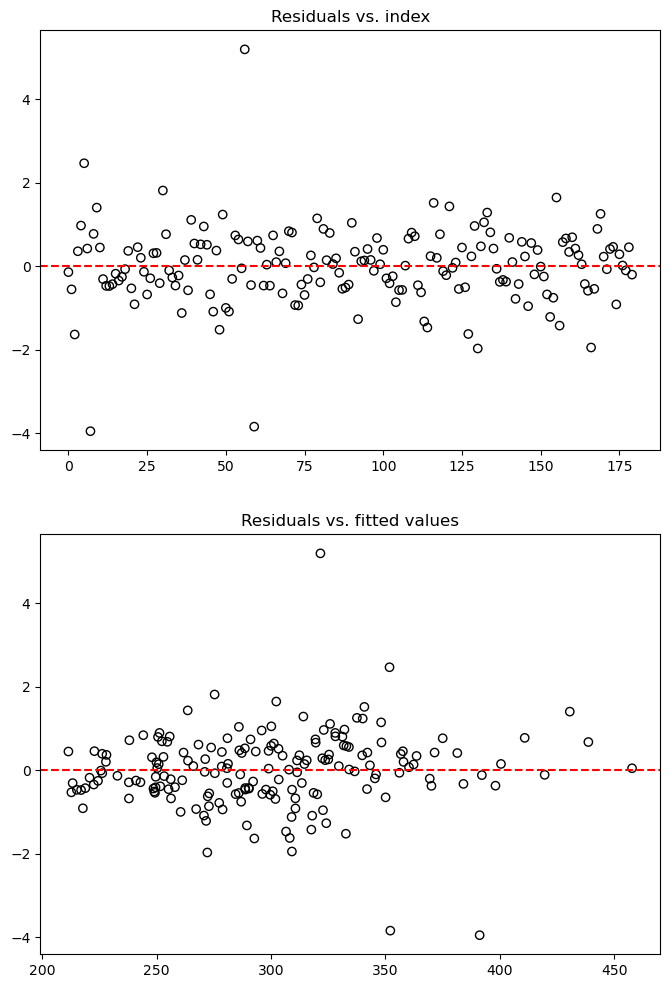

In [24]:
residual_scatter(fit2, pearson_residuals)

<h3>Assessing the normality of the residuals</h3>

In [30]:
def QQ_plot(x):
    pp = sm.ProbPlot(x, fit=True)
    qq = pp.qqplot(marker='o', markerfacecolor='none', markeredgecolor='black', alpha=0.4)
    sm.qqline(qq.axes[0], line='45', fmt='r--')

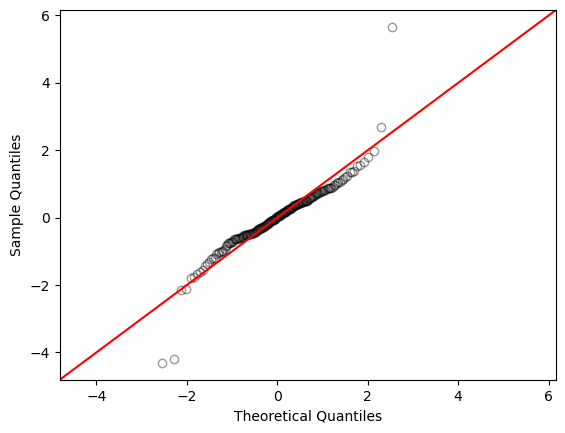

In [31]:
QQ_plot(pearson_residuals)

<h3>Assessing the normality of the predictions of the random effects</h3>

In [28]:
random_effects_preds = re_preds(fit2)

In [29]:
random_effects_preds

,Intercept,Days
308,1.8547,9.2364
309,-40.0223,-8.6175
310,-38.7232,-5.4344
330,23.9033,-4.8582
331,22.3963,-3.1048
332,9.0520,-0.2822
333,16.8512,-0.2410
334,-7.2802,1.0863
335,0.1385,-10.7982
337,34.5134,8.6315


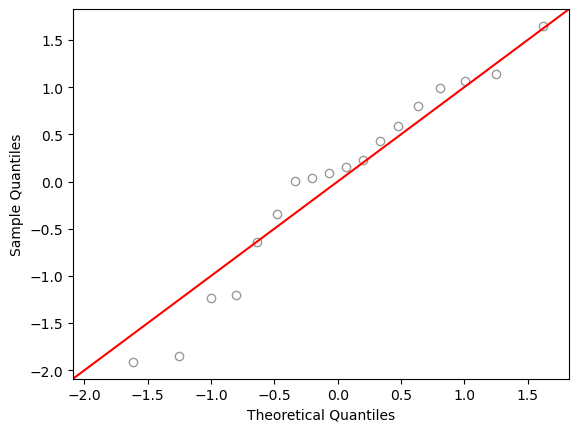

In [36]:
QQ_plot(random_effects_preds['Intercept'].values)

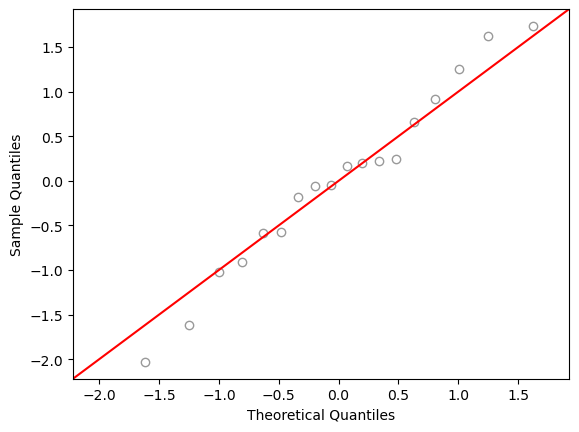

In [37]:
QQ_plot(random_effects_preds['Days'].values)

<h3>Scatter plots of the random effects</h3>

In [75]:
def re_scatter(x):
    """
    Args:
    x -- the random effects predictions
    """
    plt.figure(figsize=(8,6), dpi=100)
    plt.scatter(x.index.values, x.values, facecolors='none', edgecolors='black')
    plt.axhline(y=0, color='red', linestyle='--')

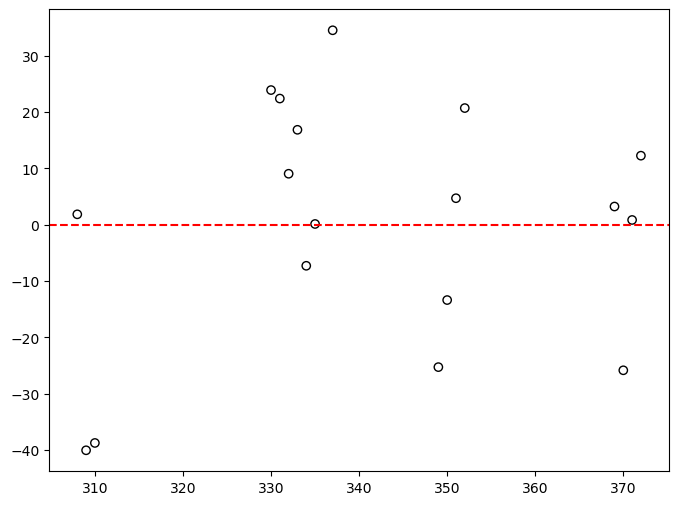

In [76]:
re_scatter(random_effects_preds['Intercept'])

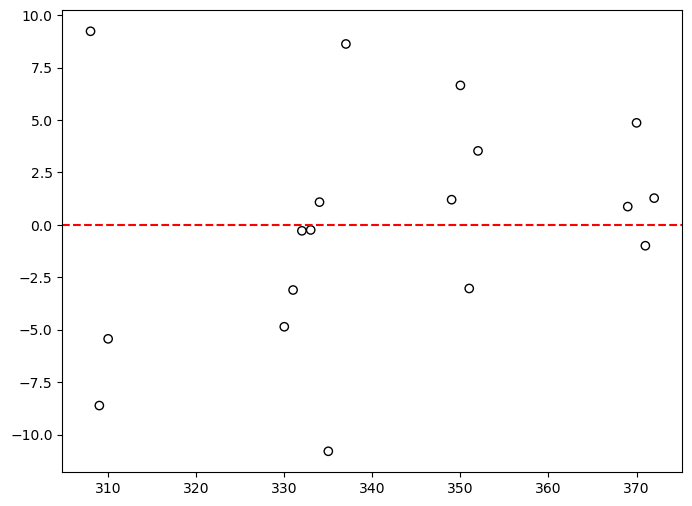

In [77]:
re_scatter(random_effects_preds['Days'])

In [80]:
print(random_effects_preds.index.values)

[308 309 310 330 331 332 333 334 335 337 349 350 351 352 369 370 371 372]


<h3>Task 6</h3>

In [4]:
gun = pd.read_csv('/Users/herrakaava/Documents/school/sekamallit/week_3/Gun.csv', index_col=0)

In [5]:
gun.head()

,rounds,Method,Team,Physique
1,20.2,M1,T1S,Slight
2,14.2,M2,T1S,Slight
3,22.0,M1,T1A,Average
4,14.1,M2,T1A,Average
5,23.1,M1,T1H,Heavy


In [6]:
gun.shape

(36, 4)

In [7]:
gun.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 1 to 36
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rounds    36 non-null     float64
 1   Method    36 non-null     object 
 2   Team      36 non-null     object 
 3   Physique  36 non-null     object 
dtypes: float64(1), object(3)
memory usage: 1.4+ KB


In [8]:
gun.isna().any()

rounds      False
Method      False
Team        False
Physique    False
dtype: bool

In [10]:
def model_uno(df):
    """
    This model allows each level of the grouping variable (Team)
    to have its own random intercept (i.e., teams can have different baselines)
    """
    model = smf.mixedlm(formula='rounds ~ Method + Physique',
                        data=gun,
                        groups='Team',
                        re_formula='1')
    fit = model.fit()
    return fit

In [13]:
def model_dos(df):
    """
    Just your regular regression model without random effects.
    """
    model = smf.ols(formula='rounds ~ Method + Physique',
                    data=gun)
    fit = model.fit()
    return fit

In [21]:
def violin(data):
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    sns.violinplot(x="Method", y="rounds", hue="Physique", data=data, zorder=2)
    plt.grid(True, zorder=1, alpha=0.5)

In [16]:
fitt_1 = model_uno(gun)
fitt_2 = model_dos(gun)

In [17]:
print(fitt_1.summary())

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   rounds  
No. Observations:     36        Method:               REML    
No. Groups:           9         Scale:                2.0577  
Min. group size:      4         Log-Likelihood:       -65.2476
Max. group size:      4         Converged:            Yes     
Mean group size:      4.0                                     
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          23.639    0.776  30.457 0.000 22.118 25.160
Method[T.M2]       -8.511    0.478 -17.800 0.000 -9.448 -7.574
Physique[T.Heavy]  -0.892    1.044  -0.854 0.393 -2.938  1.155
Physique[T.Slight]  0.742    1.044   0.710 0.478 -1.305  2.788
Team Var            1.121    0.730                            



In [18]:
print(fitt_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 rounds   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     76.82
Date:                Thu, 03 Oct 2024   Prob (F-statistic):           1.04e-14
Time:                        11:39:04   Log-Likelihood:                -68.118
No. Observations:                  36   AIC:                             144.2
Df Residuals:                      32   BIC:                             150.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             23.6389      0

- Model1 allows the teams to have different baselines, whereas Model2 does not.
- Since the teams are formed by similar physiques, the groups are likely to be correlated, and random effects may be appropriate to deal with this.

$\quad \boldsymbol{\rightarrow} \,$ choose the model that allows the random intercepts

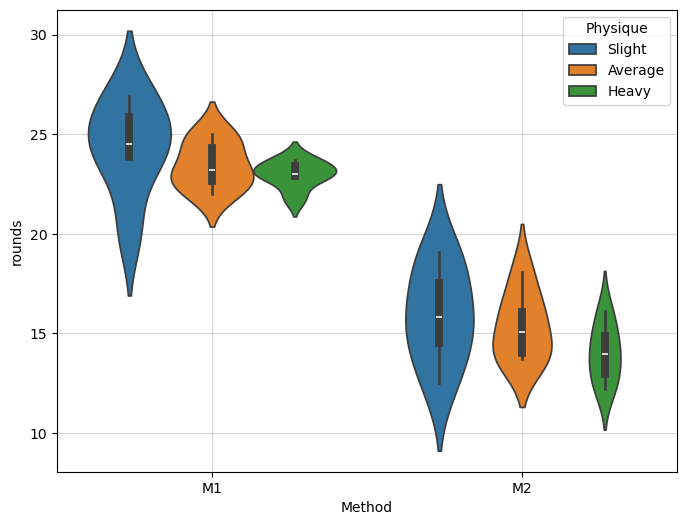

In [22]:
violin(gun)

In [24]:
gun.groupby('Physique')['rounds'].mean()

Physique
Average    19.383333
Heavy      18.491667
Slight     20.125000
Name: rounds, dtype: float64

In [34]:
def ICC(s1, s2):
    """
    Args:
    s1 -- the variance between the groups (the variance of the random intercepts)
    s2 -- the variance within the groups (residual)
    """
    return s1 / (s1 + s2)

In [35]:
ICC(s1=1.121, s2=2.0577)

0.3526598924088464

- 35% of the variance in the response is linked to the variance **between** the groups (and 65% within the groups)
- [See reference on ICC](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6645485/)

In [64]:
print(fitt_1.summary())

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   rounds  
No. Observations:     36        Method:               REML    
No. Groups:           9         Scale:                2.0577  
Min. group size:      4         Log-Likelihood:       -65.2476
Max. group size:      4         Converged:            Yes     
Mean group size:      4.0                                     
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          23.639    0.776  30.457 0.000 22.118 25.160
Method[T.M2]       -8.511    0.478 -17.800 0.000 -9.448 -7.574
Physique[T.Heavy]  -0.892    1.044  -0.854 0.393 -2.938  1.155
Physique[T.Slight]  0.742    1.044   0.710 0.478 -1.305  2.788
Team Var            1.121    0.730                            



In [79]:
fitt_1.conf_int()

,0,1
Intercept,22.117668,25.160110
Method[T.M2],-9.448270,-7.573952
Physique[T.Heavy],-2.938394,1.155060
Physique[T.Slight],-1.305060,2.788394
Team Var,-0.453004,1.542912


In [86]:
def TUKEY_HSD(x):
    result = pairwise_tukeyhsd(endog=x['rounds'],
                               groups=x['Physique'],
                               alpha=0.05)
    print(result)

In [87]:
TUKEY_HSD(gun)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Average  Heavy  -0.8917 0.8904 -5.6505 3.8671  False
Average Slight   0.7417 0.9227 -4.0171 5.5005  False
  Heavy Slight   1.6333 0.6798 -3.1255 6.3921  False
----------------------------------------------------
